In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit

import time

import numpy as onp
from numpy import genfromtxt

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import scipy.special as ss
import scipy.signal as sig
import scipy.interpolate as interp

In [3]:
# general work flow
# read in CSV file
mcsol = genfromtxt('mcsolgauss.csv',delimiter=',')
print(mcsol.shape)

(401,)


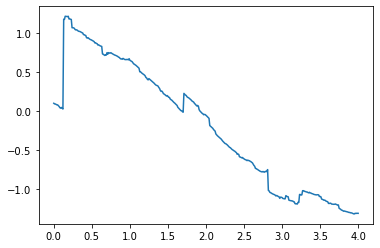

In [4]:
# constant diffusion
g = 0.25

# levy alpha parameter
alpha = 1.0

# time step
h = 0.01

# time vector
tvec = np.arange(mcsol.shape[0])*h

plt.plot(tvec, mcsol)
plt.show()

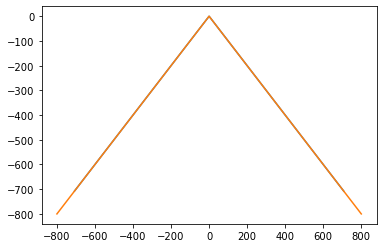

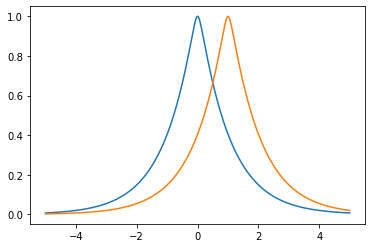

In [5]:
# for stretch = 1, this is an equispaced grid on the closed interval [-lmax, lmax]
# for stretch > 1, this is a way to create a non-equispaced grid on [-lmax, lmax]
#                  that is highly concentrated near the origin
npts = 1601
stretch = 1.0
lmax = 800

du = 2.0/(npts - 1)
startvec = -1.0 + np.arange(npts)*du
uvec = lmax*np.sign(startvec)*(np.abs(startvec)**stretch)

# this is a scaling factor used in all the collocation functions below
zeta = 1.0

# CHARBONNIER FUNCTIONS, smoothed versions of the above unnormalized Laplace PDF
@jit
def xi(u):
    return np.exp(-(np.sqrt((u/zeta)**2 + 0.01) - 0.1))

# comparing, on a log scale, our chosen collocation function versus the unnormalized Laplace
plt.plot(uvec, np.log(xi(uvec)))
plt.plot(uvec, -np.abs(uvec/zeta))
plt.show()

# checking to see how much overlap we have on our grid in u space
uuvec = np.linspace(-5,5,401)
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 0]))
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 1]))
plt.show()

In [8]:
# all the matrices are defined in the notes
udiffmat = (np.expand_dims(uvec,0) - np.expand_dims(uvec,0).T)
JJ = 5
ximats = []
for j in range(4*JJ+1):
    ximats.append( xi(udiffmat + j - 2*JJ) )

ximats = np.stack(ximats, axis=0)
print(ximats.shape)
    
a = (1+0j)*ximats[2*JJ]
d = (1+0j)*np.diag(np.exp(-h*np.abs(uvec*g)**alpha))

(21, 1601, 1601)


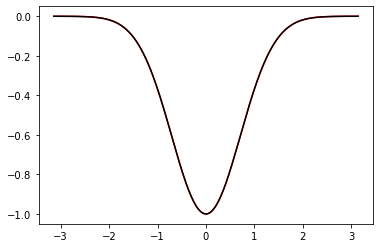

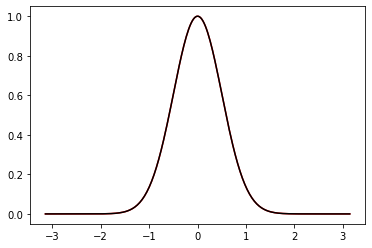

In [9]:
# set up true Fourier coefficients
truecoefs = onp.zeros(2*JJ+1, dtype=onp.complex128)
for j in range(-JJ, JJ+1):
    truecoefs[j+JJ] = (-1j/(4*onp.sqrt(onp.pi)))*onp.exp(-j**2/4)*(ss.erfi(j/2 - 1j*onp.pi) - ss.erfi(j/2 + 1j*onp.pi))

# check whether these coefficients work for f(x)
xmax = onp.pi
xpts = 256
xvec = onp.linspace(-xmax, xmax, xpts)
testfn = onp.zeros(xpts, dtype=onp.complex128)
for j in range(-JJ, JJ+1):
    testfn += truecoefs[j+JJ]*onp.exp(1j*j*xvec)

plt.plot(xvec, onp.real(testfn), color='red')
plt.plot(xvec, -onp.exp(-xvec**2), color='black')
plt.show()

# check whether these coefficients work for f^2(x)
# note convolution below
testfn = onp.zeros(xpts, dtype=onp.complex128)
for k in range(-2*JJ, 2*JJ+1):
    thiscoef = 0
    for j in range(-JJ, JJ+1):
        if onp.abs(k-j) <= JJ:
            thiscoef += truecoefs[j+JJ]*truecoefs[k-j+JJ]
    testfn += thiscoef*onp.exp(1j*k*xvec)

plt.plot(xvec, onp.real(testfn), color='red')
plt.plot(xvec, onp.exp(-2*xvec**2), color='black')
plt.show()

In [10]:
# by hand version of scipy.signal.convolve
# convcoefs = np.zeros(4*JJ+1, dtype=np.complex128)
# for k in range(-2*JJ, 2*JJ+1):
#     for j in range(-JJ, JJ+1):
#         if np.abs(k-j) <= JJ:
#             convcoefs[k+2*JJ] += truecoefs[j+JJ]*truecoefs[k-j+JJ]

start = time.time()

b = 1j*h*np.einsum('i,ijk->jk',truecoefs, ximats[JJ:(3*JJ+1),:,:] ) @ np.diag(uvec)
convcoefs = sig.convolve(truecoefs, truecoefs)
b += -0.5*h**2*np.einsum('i,ijk->jk',convcoefs, ximats) @ np.diag(uvec**2)

end = time.time()
print(end - start)

1.195878505706787


In [ ]:
# SLOW VERSION
# this b is actually b - a
# start = time.time()

# b = np.zeros((npts, npts), dtype=np.complex128)
# for j in range(-JJ, JJ+1):
#     b += 1j*truecoefs[j+JJ]*h*ximats[j+2*JJ,:,:] @ np.diag(uvec)
# for k in range(-2*JJ, 2*JJ+1):
#     thiscoef = 0
#     for j in range(-JJ, JJ+1):
#         if np.abs(k-j) <= JJ:
#             thiscoef += truecoefs[j+JJ]*truecoefs[k-j+JJ]
#     b += -0.5*h**2*thiscoef*ximats[k+2*JJ,:,:] @ np.diag(uvec**2)

# end = time.time()
# print(end - start)

# np.sum(np.abs(bnew - b))

In [11]:
propagator = np.linalg.inv(a - d @ b.T) @ d @ a

# check stability of propagator
np.max(np.abs(np.linalg.eig(propagator)[0]))

# # no splitting -- warning, probably unstable
# # propagator = np.linalg.inv(a) @ d @ (a + b)

DeviceArray(1., dtype=float64)

(2000,)


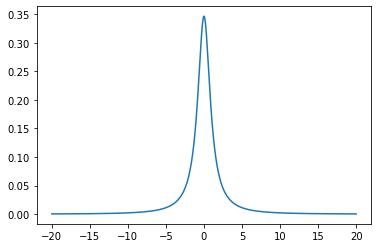

In [17]:
xmax = 20
xpts = 2000
xvec = np.linspace(-xmax, xmax, xpts)
ftmat = np.exp(-1j * np.expand_dims(uvec,1) @ np.expand_dims(xvec, 0))

base = onp.loadtxt('charboninv.csv')
print(base.shape)
plt.plot(xvec,base)

charboninv = interp.interp1d(xvec, base)
charbs = np.array(list(map(charboninv, mcsol[1:]))) 

In [26]:
def oldconstr(theta):
    coefs = onp.zeros(2*JJ+1, dtype=onp.complex128)
    coefs[JJ:] += theta[:(JJ+1)]
    coefs[(JJ+1):] += 1j*theta[(JJ+1):]
    coefs[:JJ] = onp.conj(onp.flipud(coefs[(JJ+1):]))
    newcoefs = np.concatenate([np.flipud(theta[1:(JJ+1)]), theta[:(JJ+1)]])
    newcoefs += np.concatenate([-1j*np.flipud(theta[(JJ+1):]),np.array([0.]),1j*theta[(JJ+1):]])
    return np.sum(np.abs( coefs - newcoefs ))

oldconstr(truecoefs)

DeviceArray(0., dtype=float64)

In [30]:
# write a function
@jit
def myinterp(xvec, fval, xnew):
    inds = np.searchsorted(xvec, xnew)
    ar = np.arange(xnew.shape[0])
    dx = xvec[1] - xvec[0]
    fnew = (np.diag(fval[:,inds-1]) * (xvec[inds] - xnew) + np.diag(fval[:,inds]) * (xnew - xvec[inds-1]))/dx
    return fnew


# in this function, we take the first JJ+1 elements of theta to be the real parts of the coefs
# then the next JJ elements of theta to be the imag parts of coefs[1:]
@jit
def loglik(theta):
    # construct coefficients
    # coefs = np.zeros(2*JJ+1, dtype=np.complex128)
    # coefs[JJ:] += theta[:(JJ+1)]
    # coefs[(JJ+1):] += 1j*theta[(JJ+1):]
    # coefs[:JJ] = np.conj(np.flipud(coefs[(JJ+1):]))
    coefs = np.concatenate([np.flipud(theta[1:(JJ+1)]), theta[:(JJ+1)]])
    coefs += np.concatenate([-1j*np.flipud(theta[(JJ+1):]),np.array([0.]),1j*theta[(JJ+1):]])
    
    # non-jit'able version
    # utilize np.einsum and scipy.signal.convolve
    b = 1j*h*np.einsum('i,ijk->jk',coefs, ximats[JJ:(3*JJ+1),:,:] ) @ np.diag(uvec)
    convcoefs = np.convolve(coefs, coefs)
    b += -0.5*h**2*np.einsum('i,ijk->jk',convcoefs, ximats) @ np.diag(uvec**2)
    
    # jit'able version
    # b = np.zeros((npts, npts), dtype=np.complex128)
    # for j in range(-JJ, JJ+1):
    #     b += 1j*coefs[j+JJ]*h*ximats[j+2*JJ,:,:] @ np.diag((1+0j)*uvec)
    # for k in range(-2*JJ, 2*JJ+1):
    #     thiscoef = 0
    #     for j in range(-JJ, JJ+1):
    #         if np.abs(k-j) <= JJ:
    #             thiscoef += coefs[j+JJ]*coefs[k-j+JJ]
    #     b += -0.5*h**2*(1+0j)*thiscoef*ximats[k+2*JJ,:,:] @ np.diag((1+0j)*uvec**2)
    
    numsteps = 401
    regsig = 0.005
    gammax0 = np.exp(1j*np.outer(uvec,mcsol[0:(numsteps-1)]))
    gammax0 = np.expand_dims(np.exp(-(regsig**2)*(uvec**2)/2),1) * gammax0
    gammax1 = np.linalg.solve(a - d @ b.T, d @ a @ gammax0) 
    allpdfs = myinterp(xvec, np.real(gammax1.T @ ftmat), mcsol[1:])
    
    loglik = np.log( allpdfs * charbs )
                    
    return np.sum(loglik)

In [31]:
loglik(np.array(truecoefs)) 

DeviceArray(1252.53868, dtype=float64)

In [ ]:
thetavec = np.linspace(0.5,1.5,100)

In [ ]:
nreps = 101
nr2 = (nreps-1)//2
thetamat = np.tile(truecoefs,(nreps,1))
for j in range(nreps):
    thetamat[j,0] = truecoefs[0] + (j-nr2)/nr2


In [ ]:
llvec = np.array(list(map(loglik, thetamat)))

In [ ]:
plt.plot(thetavec,llvec)

In [ ]:
thetavec[np.argmax(llvec)]

In [ ]:
np.argsort([3.0,4.0,-1.0,0.0,3.0])[1]